# Sozioökonomische Deprivation als Prädiktor für das Steueraufkommen der Gemeinden zwischen 1998 und 2014
## Ziel
Mit diesem Notebook wird analysiert, inwiefern sich sozioökonomische Deprivation als Prädiktor für das Steueraufkommen der Gemeinden eignet. Um die [Nachvollziehbarkeit](http://ropensci.github.io/reproducibility-guide/sections/introduction/) der Einschätzung zur verbessern das Ergebnis als Notebook bereitgestellt.

## Statistische Analysen
Die Analysen werden mit dem freien Programmpaket [R](https://www.r-project.org/) durchgeführt. Alle Schritte werden erläutert.

In [96]:
# Working Directory
setwd("~/Notebooks")

# Libraries provided for reproducability
library("tidyverse",quiet=T)
library("haven")
library("viridis")

# Options for Graphic Output
options(repr.plot.width=6, repr.plot.height=3.375)

# Datenquellen
## Gemeindefinanzen: INKAR
Die verwendeten Daten zur Gemeindefinanzierung stammen aus der [INKAR-Online Datenbank](http://www.inkar.de) des Bundesinstitut für Bau-, Stadt- und Raumforschung (BBSR) im Bundesamt für Bauwesen und Raumordnung (BBR). Sie sind frei zugänglich und können auf Ebene der Gemeindeverbände für den Zeitraum 1995 bis 2015 *(Stand: 5.6.2018)* bezogen werden.

In [97]:
# Finanzen
options(warn=-1)
Gemeindefinanzen <- suppressMessages(read_delim("data/Gemeindefinanzen_1995_2015.csv",";", escape_double = FALSE, locale = locale(date_names = "de",
decimal_mark = ","), trim_ws = TRUE, skip = 1))
Gemeindefinanzen <- Gemeindefinanzen %>%  rename(Kennziffer_Gemeindeverband=X1,Name=X2,Typ=X3) %>% gather(Jahr,Steuereinnahmen_pro_EW,4:24) %>% 
  mutate(Jahr=as.numeric(Jahr), Kennziffer_Gemeindeverband=as.numeric(Kennziffer_Gemeindeverband))
options(warn=0)
head(Gemeindefinanzen)

Kennziffer_Gemeindeverband,Name,Typ,Jahr,Steuereinnahmen_pro_EW
1001000,"Flensburg, Stadt",Gemeinde,1995,469.0
1002000,"Kiel, Landeshauptstadt",Gemeinde,1995,476.2
1003000,"Lübeck, Hansestadt",Gemeinde,1995,471.9
1004000,"Neumünster, Stadt",Gemeinde,1995,447.9
1051011,"Brunsbüttel, Stadt",Gemeinde,1995,606.5
1051044,"Heide, Stadt",Gemeinde,1995,467.3


## Sozioökonomische Deprivation: German Index auf Deprivation (GISD)
Für Deutschland sind regionale Unterschiede für verschiedene Gesundheitsindikatoren dokumentiert, die auch mit sozioökonomischen Unterschieden assoziiert sind. Der „German Index of Socioeconomic Deprivation“ (GISD) wird auf Ebene der Gemeindeverbände, der Landkreise und kreisfreien Städte sowie der Regierungsbezirke ab 1998 generiert. Er ist mit Aggregatdaten sowie Individualdaten der Studie Gesundheit in Deutschland assoziiert und wird für die Nutzung in der Forschung und Gesundheitsberichterstattung des Bundes und der Länder bereitgestellt. Er soll dazu beitragen, neue Datenquellen für die Analyse des Zusammenhangs von sozialer Ungleichheit und Gesundheit zu erschließen. Der Index kann [hier heruntergeladen werden](http://lekroll.github.io/GISD), nähere Informationen zur Indexkonstruktion sind [hier](https://edoc.rki.de/handle/176904/2648) verfügbar.

In [103]:
# GISD in Stata long format dataset
download.file("https://github.com/lekroll/GISD/blob/master/Revisions/2018/Bund/Gemeindeverband/Gemeindeverband_long.dta?raw=true",
              "data/Gemeindeverband_long.dta",mode = "wb")
GISD <- read_dta("data/Gemeindeverband_long.dta") %>%
        mutate(Kennziffer_Gemeindeverband= as.numeric(as.character(Kennziffer_Gemeindeverband)), Jahr=as.numeric(as.character(Jahr)))
head(GISD)

Kennziffer_Gemeindeverband,Name_Gemeindeverband,Jahr,Bevoelkerung,GISD_Score,GISD_5,GISD_10,GISD_k
1001000,"Flensburg, Stadt",1998,84694,0.856489,5,10,3
1001000,"Flensburg, Stadt",1999,84694,0.834273,5,10,3
1001000,"Flensburg, Stadt",2000,84694,0.764017,5,9,3
1001000,"Flensburg, Stadt",2001,84694,0.713020,5,9,3
1001000,"Flensburg, Stadt",2002,84694,0.769248,5,9,3
1001000,"Flensburg, Stadt",2003,84694,0.742066,5,9,3


## Zusammenspielen der Datensätze
Die Daten von INKAR lassen sich mit dem GISD anhand der Zugehörigen Regionalkennziffer zusammenführen. Hierfür müssen die Bezeichnung der Schlüsselvariable in beiden Datensätzen und der Datentyp der Schlüsselvariable (numerisch oder Zeichen) ggf. vereinheitlicht werden.

In [99]:
Comparison <- left_join(Gemeindefinanzen,GISD,by=c("Kennziffer_Gemeindeverband","Jahr")) %>% filter(!is.na(GISD_Score))
Comparison <- Comparison %>% filter(!is.na(GISD_Score) & !is.na(Steuereinnahmen_pro_EW))
head(Comparison)

Kennziffer_Gemeindeverband,Name,Typ,Jahr,Steuereinnahmen_pro_EW,Name_Gemeindeverband,Bevoelkerung,GISD_Score,GISD_5,GISD_10,GISD_k
1001000,"Flensburg, Stadt",Gemeinde,1998,524.7,"Flensburg, Stadt",84694,0.856489,5,10,3
1002000,"Kiel, Landeshauptstadt",Gemeinde,1998,588.0,"Kiel, Landeshauptstadt",243148,0.729595,5,9,3
1003000,"Lübeck, Hansestadt",Gemeinde,1998,473.5,"Lübeck, Hansestadt",214420,0.845004,5,10,3
1004000,"Neumünster, Stadt",Gemeinde,1998,495.6,"Neumünster, Stadt",77588,0.940591,5,10,3
1051011,"Brunsbüttel, Stadt",Gemeinde,1998,1049.7,"Brunsbüttel, Stadt",12642,0.790742,5,9,3
1051044,"Heide, Stadt",Gemeinde,1998,545.1,"Heide, Stadt",21303,0.833469,5,10,3


# Vergleich von GISD und Gemeindefinanzen
Im Folgenden erfolgt zuerst ein graphischer und anschließend ein regressionsbasierter Vergleich.
### Graphisch

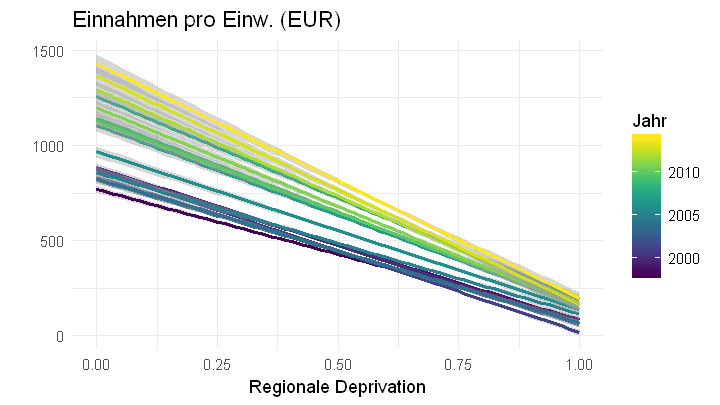

In [100]:
# Comparison 
ggplot(Comparison,aes(x=GISD_Score,y=Steuereinnahmen_pro_EW, group=Jahr, colour=Jahr)) + 
geom_smooth(method="gam") + scale_colour_viridis() + theme_minimal() +
labs(title="Einnahmen pro Einw. (EUR)", y="", x="Regionale Deprivation")

## Korrelation

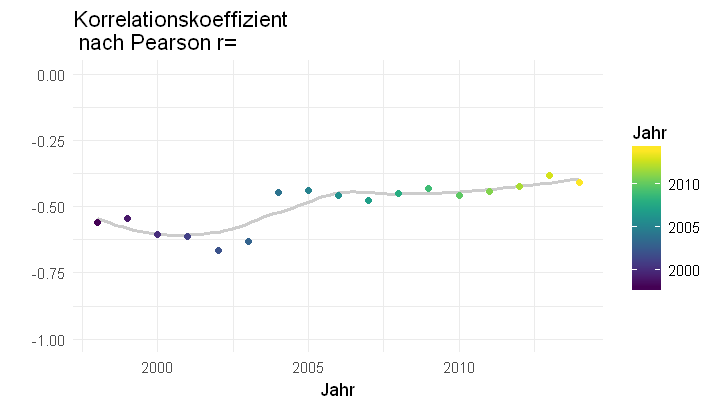

In [101]:
ggplot(Comparison %>% group_by(Jahr) %>% summarise(Korrelation = cor(Steuereinnahmen_pro_EW,GISD_Score)),
       aes(x=Jahr,y=Korrelation, colour=Jahr)) + geom_smooth(method="loess",se=F,colour="grey80") +
geom_point()+ scale_colour_viridis() + scale_y_continuous(limits=c(-1,0)) + theme_minimal() +
labs(y="",title="Korrelationskoeffizient \n nach Pearson r=")

# Anpassungsgüte

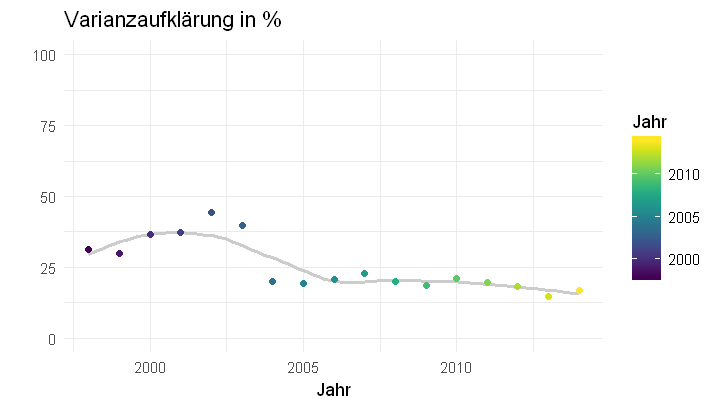

In [102]:
ggplot(Comparison %>% group_by(Jahr) %>% summarise(Varianzaufklärung = (cor(Steuereinnahmen_pro_EW,GISD_Score)^2)*100),
       aes(x=Jahr,y=Varianzaufklärung, colour=Jahr)) +
geom_smooth(method="loess",se=F,colour="grey80") + labs(y="", title="Varianzaufklärung in %") +
geom_point()+ scale_colour_viridis() + theme_minimal() + scale_y_continuous(limits=c(0,100))

# Fazit
Zwischen den Steuereinnahmen der Gemeindeverbände und der über den GISD approximierten Sozialstruktur der Gemeinden besteht ein starker Zusammenhang, allerdings ist die Varianzaufklärung der Gemeindefinanzen durch den GISD nur mäßig. Gründe dafür dass GISD die Steuereinnahmen nicht besser erklärt sind etwa:
* **Konjunktureffekte** 

    Das Steueraufkommen varriert in Abhängigkeit von der konjunkturellen Lage. Tendenziell ist anzunehmen, dass die Bedeutung der Einkommenssteuer und damit der Anteil der Löhne am gesamten Steueraufkommen in Phasen der Rezession höher ist als in konjunkturellen Hochphasen, in denen auch eine stärkere Bautätigkeit Treiber der Einnahmen und höhere Gewerbeeinnahmen vorliegen. 
    
    
* **Komponenten der Gemeindefinanzen** 

    Die Steuereinnahmen der Gemeinden speisen sich aus folgenden Quellen: Grundsteuer A und B + Gewerbesteuer + Einkommensteuer + Umsatzsteuer + sonstige Gemeindesteuer (Vergnügungssteuer, Hundesteuer, Getränkesteuer usw.) - Gewerbesteuerumlage. Lediglich die Einkommenssteuer ist dabei direkt mit der Sozialstruktur assoziiert und geht auch in die Konstruktion des GISD ein. Die übrigen Steuerarten weisen dagegen nur indirekte Verbindungen zur Sozialstruktur auf.